In [49]:
!pip install mitdeeplearning

In [79]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import mitdeeplearning as mdl
from IPython import display as ipythondisplay

In [51]:
songs = mdl.lab1.load_training_data()
print(songs[0])

Found 817 songs in text
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [52]:
total_songs = "\n\n".join(songs)
vocab = set(total_songs)

In [53]:
char2idx = {c:i for i,c in enumerate(vocab)}
idx2char = list(vocab)

In [54]:
vectorized_songs = np.array([char2idx[c] for c in total_songs])

In [55]:
total_songs[:10],vectorized_songs[:10]

('X:1\nT:Alex', array([49,  9, 70, 26, 27,  9, 33,  5, 39, 16]))

In [56]:
def batch(songs,seq_length,batch_size):
  n = songs.shape[0]-1
  idx = np.random.choice(n-seq_length,batch_size)
  
  input = [songs[i:i+seq_length] for i in idx]
  output = [songs[i+1:i+seq_length+1] for i in idx]

  input = np.reshape(input, [batch_size,seq_length])
  output = np.reshape(output, [batch_size,seq_length])

  return input,output

batch(vectorized_songs,10,2)

(array([[26, 62, 39, 35, 56, 55, 35, 39, 48, 62],
        [48,  8, 14, 62,  8, 56, 10,  8, 10, 41]]),
 array([[62, 39, 35, 56, 55, 35, 39, 48, 62, 39],
        [ 8, 14, 62,  8, 56, 10,  8, 10, 41, 48]]))

In [57]:
def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
  model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_input_shape=[batch_size,None]),

            tf.keras.layers.LSTM(rnn_units,return_sequences=True, recurrent_initializer='glorot_uniform', recurrent_activation='sigmoid', stateful=True),

            tf.keras.layers.Dense(vocab_size)                   
  ])

  return model

model = build_model(len(vocab),256,1024,32)

In [58]:
x,y = batch(vectorized_songs,50,32)
x.shape,model(x).shape

((32, 50), TensorShape([32, 50, 83]))

In [59]:
num_iterations = 1000
batch_size = 32 
seq_length = 100
learning_rate = 5e-3

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [60]:
model = build_model(vocab_size,embedding_dim,rnn_units,batch_size)

def train(x,y):
  with tf.GradientTape() as tape:
    y_pred = model(x)

    loss = tf.keras.losses.sparse_categorical_crossentropy(y, y_pred, from_logits=True)

  grads = tape.gradient(loss,model.trainable_variables)

  tf.keras.optimizers.Adam(learning_rate).apply_gradients(zip(grads,model.trainable_variables))

  return loss

0
100
200
300
400
500
600
700
800
900


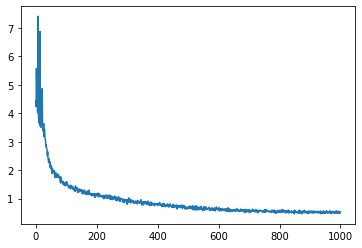

In [61]:
history = []
for iter in range(num_iterations):
  x_batch,y_batch = batch(vectorized_songs,seq_length,batch_size)
  loss = train(x_batch,y_batch)

  history.append(loss.numpy().mean())  
  if iter%100 == 0:
    print(iter)
    model.save_weights(checkpoint_prefix)
    
plt.plot(history)

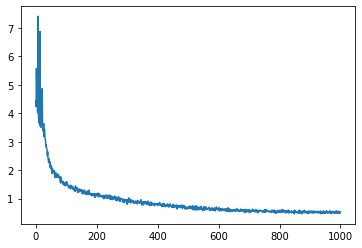

In [62]:
model.save_weights(checkpoint_prefix)
plt.plot(history)

In [68]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [69]:
def generate_text(model, start_string, generation_length):
  input = [char2idx[s] for s in start_string]
  input = tf.expand_dims(input,0)

  text_generated = []
  for i in range(generation_length):
    predict = model(input)
    predict = tf.squeeze(predict,0)

    predicted_id = tf.random.categorical(predict, num_samples=1)[-1,0].numpy()

    input = tf.expand_dims([predicted_id],0)
    text_generated.append(idx2char[predicted_id])

  return (start_string+''.join(text_generated))

In [73]:
generated_text = generate_text(model, start_string='X', generation_length=1000)

In [74]:
generated_text

"X:22GE DEF|GAB dge|dBG GAB|AGE G2E|!\nded cAF|GAG FDB|DGF EFGE|FGAF GABc|!\ndDD2 EDB,|DEF GFG|AdB AFD|!\nEFE GFE|B,EE G2A|BdB B2A|GEE E2:|!\nA|Bee efg|fdf edA|Bee efg|fdf e2f|!\ngfe dcB|ABG FED|gfe fed|cAF G2:|!\nB|AFA ABc|dAF D2A|d2:|!\nA|def a3|baf afe|def afe|def afe|dAe fdf|g3 efg a2b|a2f efe|d2B Bcd:|!\ncBc dce|dBG GAB|udB GBd|gfg aga|bgf e2f|!\ngfg a2b|a2b age|dBd ged|edB e2e|!\nedB G2B|ABB Bde|dBG G2B|!\ncAA eAA|cBA edc|BGG GAB|!\ncBc dcd|edc Bcd|ecA GED|EAA A2:|!\nB|c2e d3|B2c d3|B2d def g3|d2B cBA|!\nG2g gfg|fdf agf|g2c c2e|d=cA GcA|B2G AGE|GED D2d|BAG FGE|D3 D2G|!\nc2d e2d|cBc A2G|E2G GAB cde|d3 vellowast Des\nZ: id:dc-reel-204\nM:C\nL:1/8\nK:D Major\ndB|ADFD ADFD|ADBD cAFA|dcdB AFEA|BAGF DF/A/|!\n[1 fe|dgg2 bgg2|dggf g2fe|d=fed ^cdef|!\ngfgd bdBG|cefe dcBA|G2FA GBcd|ecAG EFGE|!\nG3B AGFD|GBdB cAGE|DEFG AFFD|EFGE D2dB|A2BG dGBG|DECE D3:|!\nA|d3f a2fa|g2af gfef|d2de fefe|aD:|!\n\nX:24\nT:'s MiFlyton's|\n\nX:f2ef|g3e dedB|c2Bc ABcA|!\ndAA2 dAFA|dBcA dcde|fcc2 dBcA|!\ndgfb afdf

In [83]:
generated_song = mdl.lab1.extract_song_snippet(generated_text)

for i,song in enumerate(generated_song):
  waveform = mdl.lab1.play_song(song)
  ipythondisplay.display(generated_song)
  
  if waveform:
    print("Generated Song:",i)
    ipythondisplay.display(waveform)
  

Found 2 songs in text


['X:22GE DEF|GAB dge|dBG GAB|AGE G2E|!\nded cAF|GAG FDB|DGF EFGE|FGAF GABc|!\ndDD2 EDB,|DEF GFG|AdB AFD|!\nEFE GFE|B,EE G2A|BdB B2A|GEE E2:|!\nA|Bee efg|fdf edA|Bee efg|fdf e2f|!\ngfe dcB|ABG FED|gfe fed|cAF G2:|!\nB|AFA ABc|dAF D2A|d2:|!\nA|def a3|baf afe|def afe|def afe|dAe fdf|g3 efg a2b|a2f efe|d2B Bcd:|!\ncBc dce|dBG GAB|udB GBd|gfg aga|bgf e2f|!\ngfg a2b|a2b age|dBd ged|edB e2e|!\nedB G2B|ABB Bde|dBG G2B|!\ncAA eAA|cBA edc|BGG GAB|!\ncBc dcd|edc Bcd|ecA GED|EAA A2:|!\nB|c2e d3|B2c d3|B2d def g3|d2B cBA|!\nG2g gfg|fdf agf|g2c c2e|d=cA GcA|B2G AGE|GED D2d|BAG FGE|D3 D2G|!\nc2d e2d|cBc A2G|E2G GAB cde|d3 vellowast Des\nZ: id:dc-reel-204\nM:C\nL:1/8\nK:D Major\ndB|ADFD ADFD|ADBD cAFA|dcdB AFEA|BAGF DF/A/|!\n[1 fe|dgg2 bgg2|dggf g2fe|d=fed ^cdef|!\ngfgd bdBG|cefe dcBA|G2FA GBcd|ecAG EFGE|!\nG3B AGFD|GBdB cAGE|DEFG AFFD|EFGE D2dB|A2BG dGBG|DECE D3:|!\nA|d3f a2fa|g2af gfef|d2de fefe|aD:|!',
 "X:24\nT:'s MiFlyton's|"]

['X:22GE DEF|GAB dge|dBG GAB|AGE G2E|!\nded cAF|GAG FDB|DGF EFGE|FGAF GABc|!\ndDD2 EDB,|DEF GFG|AdB AFD|!\nEFE GFE|B,EE G2A|BdB B2A|GEE E2:|!\nA|Bee efg|fdf edA|Bee efg|fdf e2f|!\ngfe dcB|ABG FED|gfe fed|cAF G2:|!\nB|AFA ABc|dAF D2A|d2:|!\nA|def a3|baf afe|def afe|def afe|dAe fdf|g3 efg a2b|a2f efe|d2B Bcd:|!\ncBc dce|dBG GAB|udB GBd|gfg aga|bgf e2f|!\ngfg a2b|a2b age|dBd ged|edB e2e|!\nedB G2B|ABB Bde|dBG G2B|!\ncAA eAA|cBA edc|BGG GAB|!\ncBc dcd|edc Bcd|ecA GED|EAA A2:|!\nB|c2e d3|B2c d3|B2d def g3|d2B cBA|!\nG2g gfg|fdf agf|g2c c2e|d=cA GcA|B2G AGE|GED D2d|BAG FGE|D3 D2G|!\nc2d e2d|cBc A2G|E2G GAB cde|d3 vellowast Des\nZ: id:dc-reel-204\nM:C\nL:1/8\nK:D Major\ndB|ADFD ADFD|ADBD cAFA|dcdB AFEA|BAGF DF/A/|!\n[1 fe|dgg2 bgg2|dggf g2fe|d=fed ^cdef|!\ngfgd bdBG|cefe dcBA|G2FA GBcd|ecAG EFGE|!\nG3B AGFD|GBdB cAGE|DEFG AFFD|EFGE D2dB|A2BG dGBG|DECE D3:|!\nA|d3f a2fa|g2af gfef|d2de fefe|aD:|!',
 "X:24\nT:'s MiFlyton's|"]